In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
#Loading our data
words = open(r'dataset\names.txt',mode='r').read().splitlines()
words[:10]
len(words)

32033

In [3]:
#charset
chars = sorted(list(set(''.join(words))))
S_to_I = {s:i+1 for i,s in enumerate(chars)}
S_to_I['.'] = 0
I_to_S = {i:s for s,i in S_to_I.items()}
vocab_size  = len(I_to_S)

print(I_to_S,'\n', vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 
 27


In [19]:
block_size = 8 #context length, how many characters are taken/looked at before making the next prediction
def build_dataset(words):
    X, Y = [],[]
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w +'.':
            ix = S_to_I[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(I_to_S[i] for i in context), '----->', I_to_S[ix])
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 *len(words))
n2 = int(0.9*len(words))

X_train, y_train = build_dataset(words[n1:])
X_valid, y_valid = build_dataset(words[n1:n2])
X_test , y_test = build_dataset(words[n2:])

In [59]:


from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True): #This is us initializing our linear layer ( Weight * input + bias) (Note we init our weight and bias, and our function takes fan_in & fan_out as args (input and output features))
        self.weight = torch.randn(fan_in, fan_out) / fan_in**0.5 #fan_in is just input features (in our code it is the number of embeddings*block size)(self.weight == w1 in our code above) **Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None #self-explanatory, it is the bias init to zeros
    
    def __call__(self,x): #Here we define what should happen when we call our linear layer
        self.out = x @ self.weight #Matrix multiplcation as above our logits_preact layer (h_preact above)
        if self.bias is not None:
            self.out += self.bias #Here we set condition to add bias to our matrix multiplication product is bias is not None (0)
        return self.out
    
    def parameters(self): #Here we define what happens with our parameters (Weight & Bias)
        return [self.weight] + ([] if self.bias is None else [self.bias]) #Return a list of our weights and a list of our biases
    
class BatchNorm1d: #Our BatchNorm Layer
    def __init__(self, dim , eps = 1e-5, momentum=0.1): #Initializing of our batch norm layer, that takes dim, eps, momentum as args, dim is the shape/size of input our activation layer will take
        self.eps = eps
        self.momentum  = momentum
        self.training = True   #This lets our function know that we are currently training our model (For batchNorm), hence set to true, False would be otherwise.
        
        self.gamma = torch.zeros(dim) #gamma is our BatchNorm bias, similar to our bN_bias in the code above
        self.beta = torch.ones(dim) #beta is BatchNorm gain, simliar to our bN_gain in code above
        
        self.running_mean = torch.zeros(dim) #The running mean of the batch norm function, calculated in place with the batchNorm to avoid a stage 2 computation of this stat, similar to code above
        self.running_var = torch.ones(dim)
    
    def __call__(self,x): #definig what happens when we call our BatchNorm layer (class)
        if self.training: #When in training, the following is executed
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim  = (0,1)
            xmean = x.mean(dim, keepdims=True) #We  calculate the mean along columns (axis 0) going down, for arg x that our function takes. The shape of this mean tensor would be 1, dim of x (the batch), the mean of the batch
            xvar = x.var(dim, keepdim=True) #Similar to the mean calculation above, however now we caulcate the variance, the variance of the batch
        else: #Following code is executed if we are not training the model
            xmean = self.running_mean #The mean of the batch is set to the running mean
            xvar = self.running_var #Similarly the variance of the batch is set to the running variance
        xhat = (x- xmean)/torch.sqrt(xvar+self.eps) #Normalization, ensuring the batch has a unit gaussian and 0 mean
        self.out = self.gamma + self.beta + xhat #Adding the gain and bias to our batch
        if self.training: #This code will be executed if the model is set to training
            with torch.no_grad(): #Decorator to alert Pytorch not to compute the gradients for these, as we will not backprop on them
                self.running_mean = ((1-self.momentum) * self.running_mean) + (self.momentum * xmean) #The running mean is updated with majority of what it was (0.9*r mean) and nudged (0.1) in the direction of the current mean
                self.running_var = ((1-self.momentum) * self.running_var) + (self.momentum * xvar) #Similar to the running mean update
        return self.out #Returns the output of our batch with the gain and bias
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh: #Our activation layer/class
    def __call__(self, x): #Our call function which takes our batch as an arg
        self.out = torch.tanh(x) #Applies torch.tanh to our batch and stores it as output
        return self.out #function returns the output when completed
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return []
    
class Flatten:
    def __init__(self, n):
        self.n = n
    
    def __call__(self,x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [6]:
torch.manual_seed(42) #Setting seed globally and discarding the generator

Note below, modifying the Flatten module with this idea, to create dimension batching so we can slowly feed inputs into the network in batches. **Not required to run

In [34]:
e = torch.randn(4,8,10)
explicit = torch.cat([e[:,::2,:] ,e[:,1::2,:]], dim=2)
explicit.shape
e.view(4, -1, 20).shape

(explicit == e.view(4, -1, 20)).all()

tensor(True)

----------------------------------------------------------------------

In [63]:
n_emb = 10 #Number of dimension of char embedding vectors
n_hidden = 64 #Number of neurons in hidden layer
#g = torch.Generator().manual_seed(2147843647) #seed for reproducibility
#Commented out, not in use, after creating modules Embedding which creates our Embedding table #C = torch.randn((vocab_size, n_emb)) #Indexing embedding, with shape of vocab_size and n_emb

#The model, with the implementation of the classes we created. Basically functioning like torch.Linear & torch.BatchNorm layers
model = Sequential([
    Embedding(vocab_size, n_emb),
    Flatten(2),Linear(n_emb*2, n_hidden,bias= False),BatchNorm1d(n_hidden), Tanh(),
    Flatten(2),Linear(n_hidden*2, n_hidden,bias= False),BatchNorm1d(n_hidden), Tanh(),
    Flatten(2),Linear(n_hidden*2, n_hidden,bias= False),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad(): #decorator again, to let torch know that we will not be calling backprop on these
    model.layers[-1].weight *=0.1 #apply to last layer to make model less confident
    for layer in model.layers[:-1]:
        if isinstance(layer, Linear): #Code below is applied to Linear layers in the layers list
            layer.weight *= 5/3 #apply nonlinearity gain to our Linear layers'''
            

parameters = model.parameters() #Number of parameters in our model
print(sum(p.nelement() for p in parameters), 'parameters') #total num of params in our model printed
for p in parameters:
    p.requires_grad = True #Set that parameters require gradients, so we can backprop on them

19803 parameters


In [64]:
#Same as before modified to fit new code better
step_size = 100000
batch_size = 32
loss_acq = []

for i in range(step_size):
    #Minibatch from dataset
    ix = torch.randint(0,X_train.shape[0], (batch_size, )) 
    Xtr, Ytr = X_train[ix], y_train[ix]
    
    #Forward pass
   #emb = C[Xtr] #Embedding vector
   #x = emb.view(emb.shape[0],-1) #Joined embedding to have same number of dimensions as w1 for matrix muliplication
    logits = model(Xtr)
    loss = F.cross_entropy(logits,Ytr)
    
    #Backward pass
    for p in parameters:
        p.grad =None
    loss.backward()
    
    #Update
    lr= 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #Tracking stats
    if i % 10000 == 0:
        print(f'{i:7d}/{step_size:7d}: {loss.item():.4f}')
    loss_acq.append(loss.log10().item())
    #break
        
print(loss.item())

      0/ 100000: 3.3189
  10000/ 100000: 2.3930
  20000/ 100000: 2.4150
  30000/ 100000: 1.9398
  40000/ 100000: 1.7971
  50000/ 100000: 2.0543
  60000/ 100000: 1.9095
  70000/ 100000: 1.6949
  80000/ 100000: 1.7939
  90000/ 100000: 2.0851
1.6047040224075317


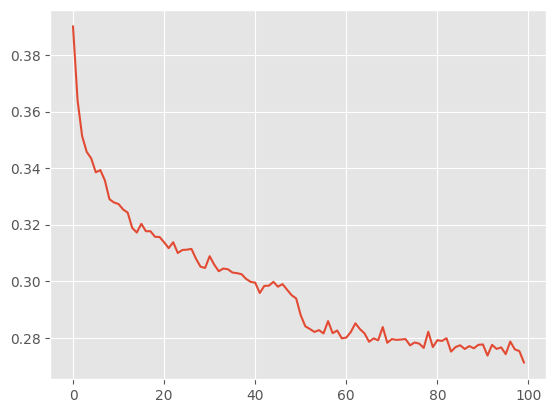

In [65]:
plt.plot(torch.tensor(loss_acq).view(-1, 1000).mean(1));

In [66]:
#Set layers to eval mode (required by Batch norm to validate the train and validation loss)
for layer in model.layers:
    layer.training = False

In [67]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, y_train),
        'valid': (X_valid, y_valid),
        'test': (X_test, y_test)
    }[split]
    logits = model(x)
    #counts = logits.exp()
    #prob = counts / counts.sum(dim=1, keepdim=True)
    #loss = -prob[torch.arange(16),Y].log().mean()
    loss = F.cross_entropy(logits, y)
    print(split,'loss:', loss.item())
    
split_loss('train')
split_loss('valid')

train loss: 1.8509202003479004
valid loss: 1.8525769710540771


In [68]:
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(I_to_S[i] for i in out))

rowen.
kantalita.
keigh.
jaeley.
tijoldem.
elicie.
simny.
rulveens.
odanne.
remexkhi.
dayrin.
ashara.
beryn.
sremina.
midhani.
jami.
savin.
sahmatra.
estyn.
sahai.
